In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR


from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)

In [26]:
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1)


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\3028427092.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1)


In [27]:
df

,Betriebe_WZ08-10,Betriebe_ep_WZ08-10,Beschäftigte_WZ08-10,Beschäftigte_ep_WZ08-10,Geleistete Arbeitsstunden_WZ08-10,Geleistete Arbeitsstunden_ep_WZ08-10,Bruttolohn- und -gehaltssumme_WZ08-10,Bruttolohn- und -gehaltssumme_ep_WZ08-10,Umsatz_WZ08-10,Umsatz_ep_WZ08-10,Inlandsumsatz_WZ08-10,Inlandsumsatz_ep_WZ08-10,Auslandsumsatz_WZ08-10,Auslandsumsatz_ep_WZ08-10,Auslandsumsatz mit der Eurozone_WZ08-10,Auslandsumsatz mit der Eurozone_ep_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-10,Betriebe_WZ08-108,Betriebe_ep_WZ08-108,Beschäftigte_WZ08-108,Beschäftigte_ep_WZ08-108,Geleistete Arbeitsstunden_WZ08-108,Geleistete Arbeitsstunden_ep_WZ08-108,Bruttolohn- und -gehaltssumme_WZ08-108,Bruttolohn- und -gehaltssumme_ep_WZ08-108,Umsatz_WZ08-108,Umsatz_ep_WZ08-108,Inlandsumsatz_WZ08-108,Inlandsumsatz_ep_WZ08-108,Auslandsumsatz_WZ08-108,Auslandsumsatz_ep_WZ08-108,Auslandsumsatz mit der Eurozone_WZ08-108,Auslandsumsatz mit der Eurozone_ep_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-108,Betriebe_WZ08-1082,Betriebe_ep_WZ08-1082,Beschäftigte_WZ08-1082,Beschäftigte_ep_WZ08-1082,Geleistete Arbeitsstunden_WZ08-1082,Geleistete Arbeitsstunden_ep_WZ08-1082,Bruttolohn- und -gehaltssumme_WZ08-1082,Bruttolohn- und -gehaltssumme_ep_WZ08-1082,Umsatz_WZ08-1082,Umsatz_ep_WZ08-1082,Inlandsumsatz_WZ08-1082,Inlandsumsatz_ep_WZ08-1082,Auslandsumsatz_WZ08-1082,Auslandsumsatz_ep_WZ08-1082,Auslandsumsatz mit der Eurozone_WZ08-1082,Auslandsumsatz mit der Eurozone_ep_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1082,Betriebe_WZ08-1083,Betriebe_ep_WZ08-1083,Beschäftigte_WZ08-1083,Beschäftigte_ep_WZ08-1083,Geleistete Arbeitsstunden_WZ08-1083,Geleistete Arbeitsstunden_ep_WZ08-1083,Bruttolohn- und -gehaltssumme_WZ08-1083,Bruttolohn- und -gehaltssumme_ep_WZ08-1083,Umsatz_WZ08-1083,Umsatz_ep_WZ08-1083,Inlandsumsatz_WZ08-1083,Inlandsumsatz_ep_WZ08-1083,Auslandsumsatz_WZ08-1083,Auslandsumsatz_ep_WZ08-1083,Auslandsumsatz mit der Eurozone_WZ08-1083,Auslandsumsatz mit der Eurozone_ep_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1083,ErzPr_Nahrungsmittel und Futtermittel,ErzPr_Sonstige Nahrungsmittel (ohne Getränke),ErzPr_Süßwaren (ohne Dauerbackwaren),ErzPr_Schokoladen und andere Süßwaren,"ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg","ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg",ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade),"ErzPr_Kaffee und Tee, Kaffee-Ersatz","ErzPr_Kaffee und Tee, Kaffee-Ersatz.1","ErzPr_Kaffee, entkoffeiniert oder geröstet","ErzPr_Kaffeemittel m. -geh.,Auszüge,Essenz.,Konzentrate","ErzPr_Grüner Tee (n. ferment.), schwarzer Tee (ferment.)",ErzPr_Kräutertees,EinfPr_Nahrungsmittel und Futtermittel,EinfPr_Sonstige Nahrungsmittel (ohne Getränke),EinfPr_Süßwaren (ohne Dauerbackwaren),"EinfPr_Kaffee und Tee, Kaffee-Ersatz",VPI_Nahrungsmittel und alkoholfreie Getränke,VPI_Nahrungsmittel,"VPI_Zucker, Marmelade, Honig und andere Süßwaren",VPI_Schokoladen,VPI_Süßwaren,VPI_Alkoholfreie Getränke,"VPI_Kaffee, Tee und Kakao",VPI_Kaffee und Ähnliches,VPI_Tee und teeähnliche Erzeugnisse,VPI_Kakaopulver oder Ähnliches,"Wert der zum Absatz bestimmten Produktion_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Wert der zum Absatz bestimmten Produktion_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge der zum Absatz bestimmten Produktion_stueck_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge de

In [20]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        #feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        #target_start = y
        #model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.weight_mond_fer + result.loc[~mask_f & mask_l, 'pred_mf'] * self.weight_fer_fer 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.weight_mond + result.loc[~mask_l,'pred_mf'] * self.weight_fer + result.loc[~mask_l,'pred_mfl'] * self.weight_lindt
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [24]:
def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train):
    target_name = 'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.'
    shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
    columns = [x for x in list(dict_lag) if x not in shares]
    df_selected_col = df.loc[:, shares + columns + [target_name]]
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    # Model
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    mod = Model( columns,
             model_start, model_middle, 
             model_end)
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    print('MSE on Train set: ', mean_squared_error(results['final'], target_train))
    results['target']=target_train
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm');
    ax.plot(results.index,results.pred_mf.values, label = 'mf');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl');
    ax.plot(results.index,results.final.values, label = 'final');
    ax.plot(results.index, target_train, color =  'red', label = 'target');
    ax.legend()
    # Predict testdata 
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    print('MSE on Test set: ', mean_squared_error(results_test['final'], target_test))
    fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax_test.plot(results_test.index,results_test.pred_m.values, label = 'm');
    ax_test.plot(results_test.index,results_test.pred_mf.values, label = 'mf');
    ax_test.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl');
    ax_test.plot(results_test.index,results_test.final.values, label = 'final');
    ax_test.plot(results_test.index,target_test, color =  'red', label = 'target');
    ax_test.legend()
    return results, results_test
    

In [32]:
columns = ['Beschäftigte_WZ08-1082',
 'Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'Umsatz_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in ['Beschäftigte_WZ08-1082',
 'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in ['Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082','ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


<Axes: >

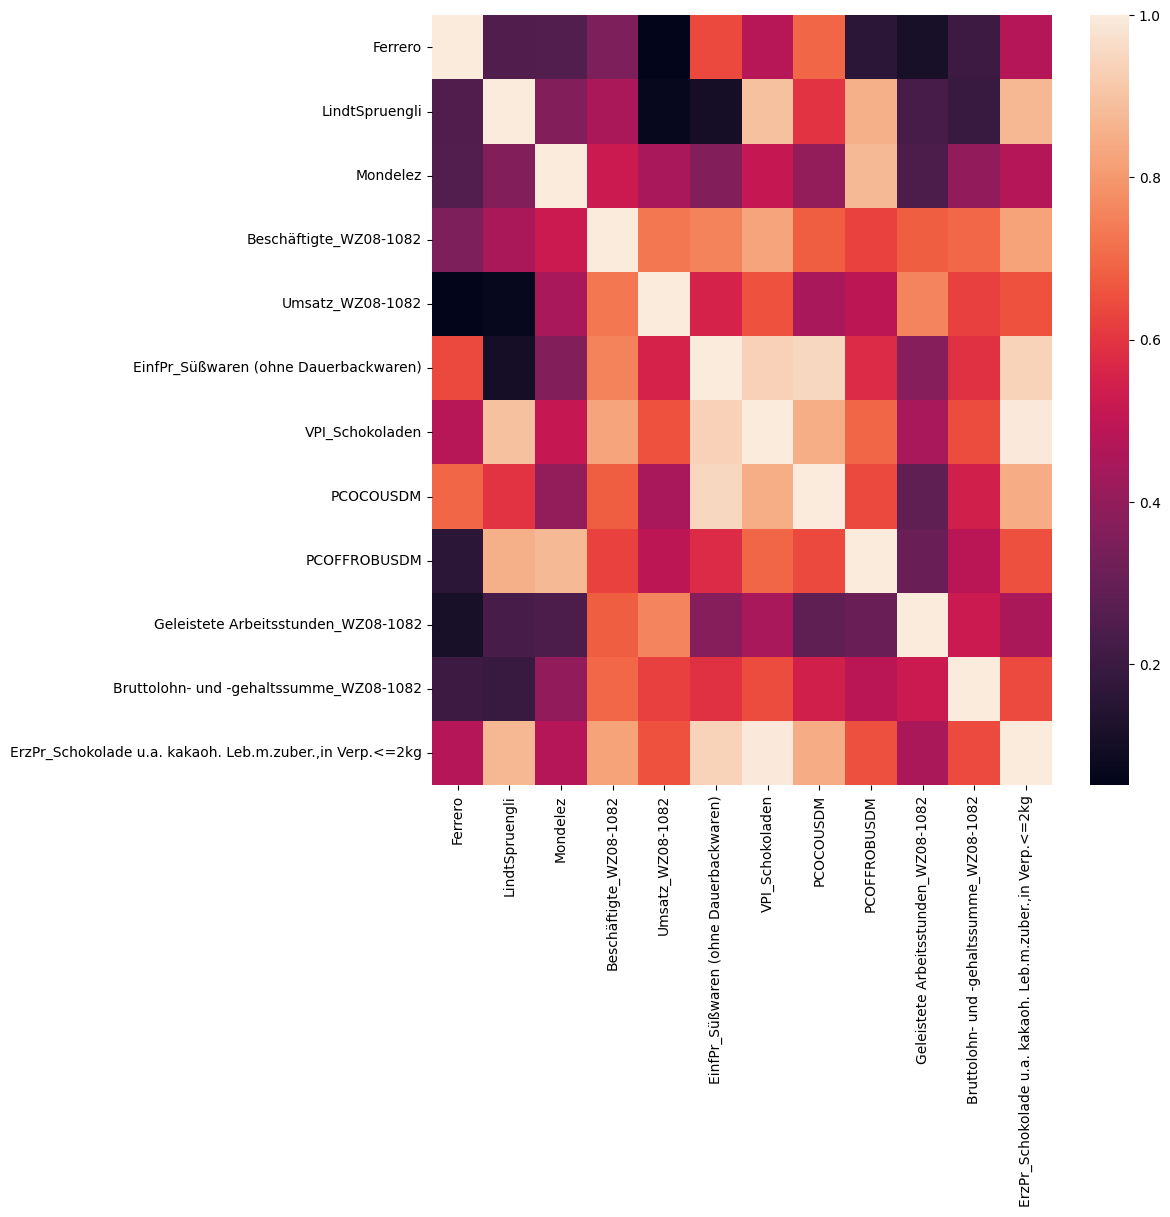

In [36]:
corr = df.loc[:,list(dict_lag)].corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Linear Regression

MSE on Train set:  1.0554088450211384e+16
MSE on Test set:  1.4211884179464072e+17


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.55344923e+08 5.53072348e+08 4.98030140e+08 4.84327978e+08
 5.06928205e+08 5.48682356e+08 5.87138050e+08 5.97440258e+08
 6.11657697e+08 5.73218520e+08 4.87578643e+08 5.32614862e+08
 5.59405812e+08 5.23811695e+08 4.70225347e+08 4.62598500e+08
 4.96252177e+08 5.31594995e+08 5.47793899e+08 5.37741607e+08
 5.48209201e+08 4.87972293e+08 4.41376023e+08 4.81897704e+08
 5.07486497e+08 4.99470967e+08 4.64600298e+08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.47224931e+08 8.43790731e+08 8.62692898e+0

(                  pred_m       pred_mf      pred_mfl         final  \
 index                                                                
 2019-01-31  5.553449e+08           NaN           NaN  5.553449e+08   
 2019-02-28  5.530723e+08           NaN           NaN  5.530723e+08   
 2019-03-31  4.980301e+08           NaN           NaN  4.980301e+08   
 2019-04-30  4.843280e+08           NaN           NaN  4.843280e+08   
 2019-05-31  5.069282e+08           NaN           NaN  5.069282e+08   
 ...                  ...           ...           ...           ...   
 2024-10-31  8.047254e+08  8.099457e+08           NaN  8.067531e+08   
 2024-11-30  6.940985e+08  6.816765e+08  6.200521e+08  6.870584e+08   
 2024-12-31  7.407195e+08  7.332413e+08  6.179656e+08  7.339796e+08   
 2025-01-31  7.444740e+08  7.335237e+08  6.708191e+08  7.379997e+08   
 2025-02-28  7.437298e+08  7.307848e+08  7.307693e+08  7.384478e+08   
 
                  target  
 index                    
 2019-01-31  46130600

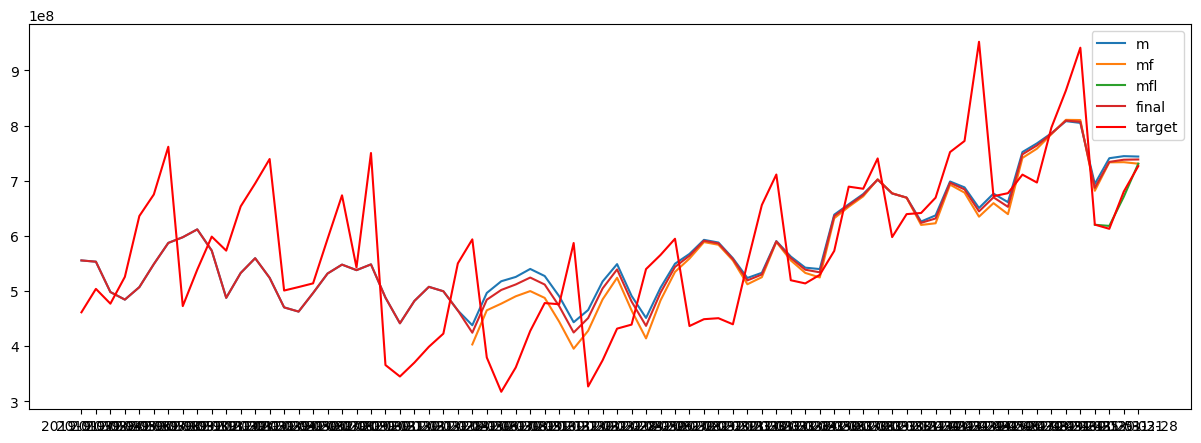

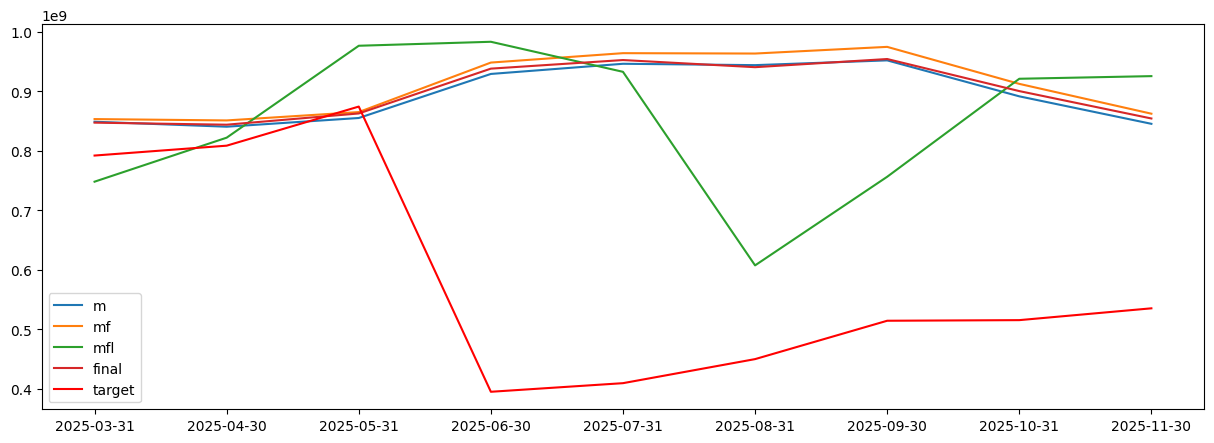

In [33]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)

## LinearSVR

MSE on Train set:  3.5129012178645984e+17
MSE on Test set:  3.535564982055639e+17


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74. 74.
 74. 74. 74. 74. 74. 74. 74. 74. 74.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[19704033.74955676 19704033.84565371 19704034.08095288 19704034.24352745
 19704034.20423345 19704033.76220428 19704033.98471146 19704034.093197

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,74.0,NaN,NaN,7.400000e+01,461306000.0
2019-02-28,74.0,NaN,NaN,7.400000e+01,503777000.0
2019-03-31,74.0,NaN,NaN,7.400000e+01,476975000.0
2019-04-30,74.0,NaN,NaN,7.400000e+01,525599000.0
2019-05-31,74.0,NaN,NaN,7.400000e+01,635907000.0
...,...,...,...,...,...
2024-10-31,74.0,257419.0,NaN,1.000345e+05,941120000.0
2024-11-30,74.0,257419.0,6.127250e+08,1.970403e+07,620313000.0
2024-12-31,74.0,257419.0,6.127250e+08,1.970403e+07,612725000.0


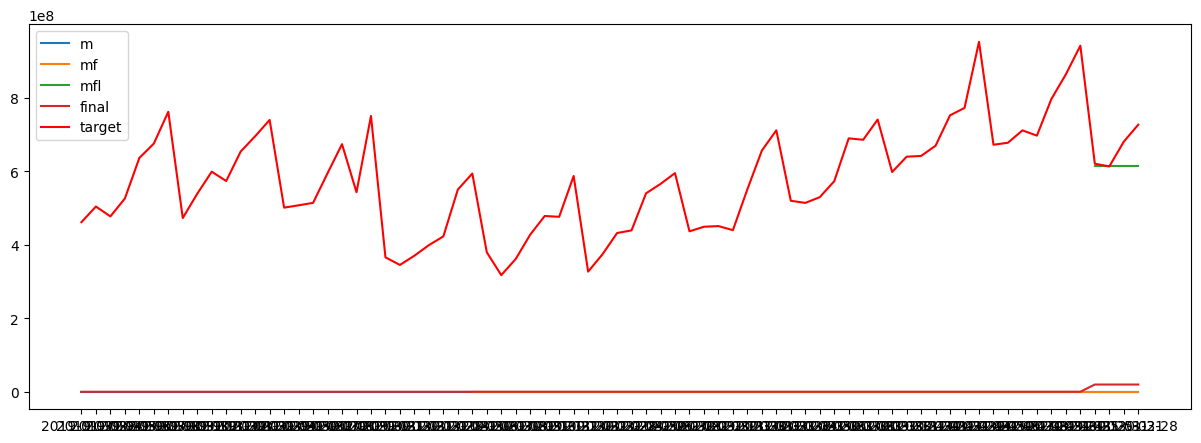

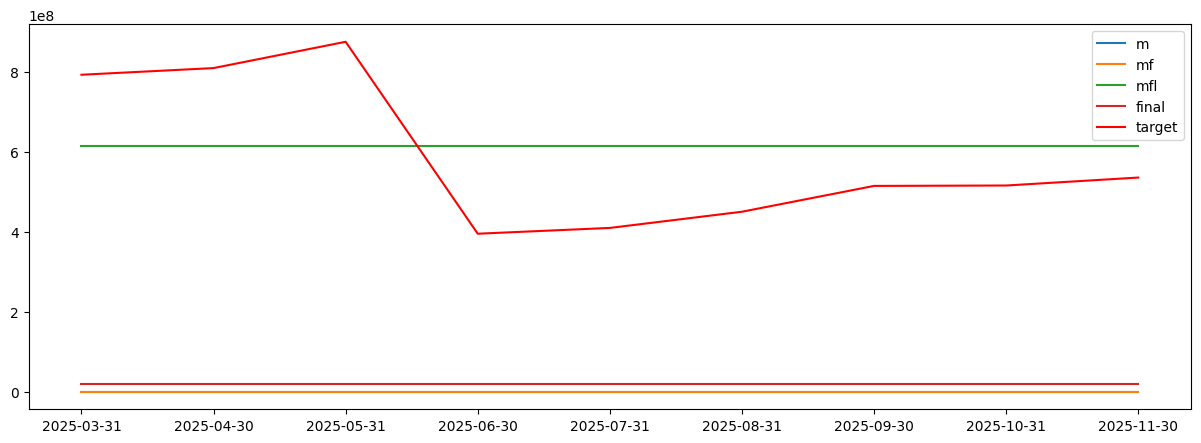

In [29]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)
results

MSE on Train set:  1.962641126209863e+16
MSE on Test set:  3.047348653413991e+16


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.72920494e+08 5.72920492e+08 5.72920491e+08 5.72920491e+08
 5.72920491e+08 5.72920492e+08 5.72920494e+08 5.72920493e+08
 5.72920494e+08 5.72920495e+08 5.72920499e+08 5.72920493e+08
 5.72920493e+08 5.72920490e+08 5.72920490e+08 5.72920492e+08
 5.72920494e+08 5.72920493e+08 5.72920491e+08 5.72920490e+08
 5.72920492e+08 5.72920492e+08 5.72920497e+08 5.72920492e+08
 5.72920490e+08 5.72920490e+08 5.72920490e+08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.83568525e+08 5.83568524e+08 5.83568524e+0

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,5.729205e+08,NaN,NaN,5.729205e+08,461306000.0
2019-02-28,5.729205e+08,NaN,NaN,5.729205e+08,503777000.0
2019-03-31,5.729205e+08,NaN,NaN,5.729205e+08,476975000.0
2019-04-30,5.729205e+08,NaN,NaN,5.729205e+08,525599000.0
2019-05-31,5.729205e+08,NaN,NaN,5.729205e+08,635907000.0
...,...,...,...,...,...
2024-10-31,5.729205e+08,594658000.0,NaN,5.813640e+08,941120000.0
2024-11-30,5.729205e+08,594658000.0,650255500.0,5.835685e+08,620313000.0
2024-12-31,5.729205e+08,594658000.0,650255500.0,5.835685e+08,612725000.0


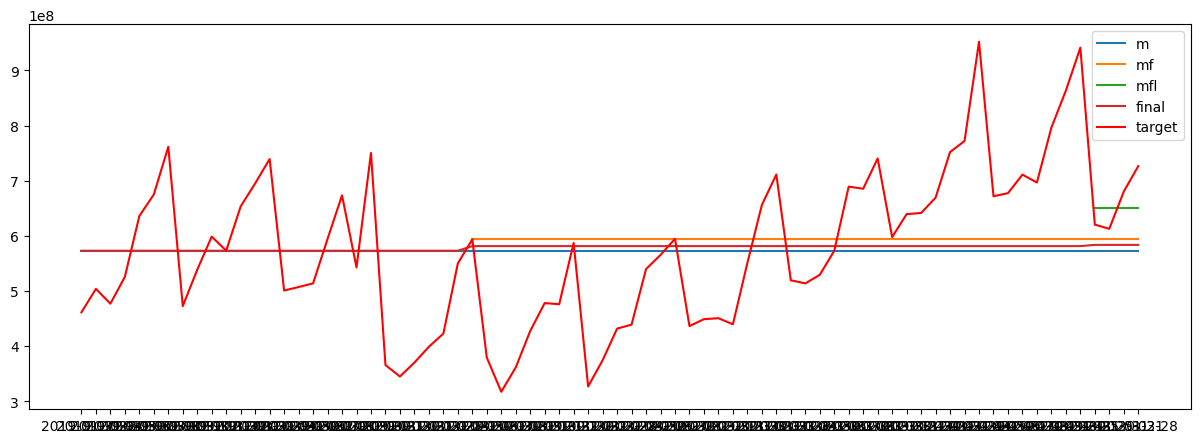

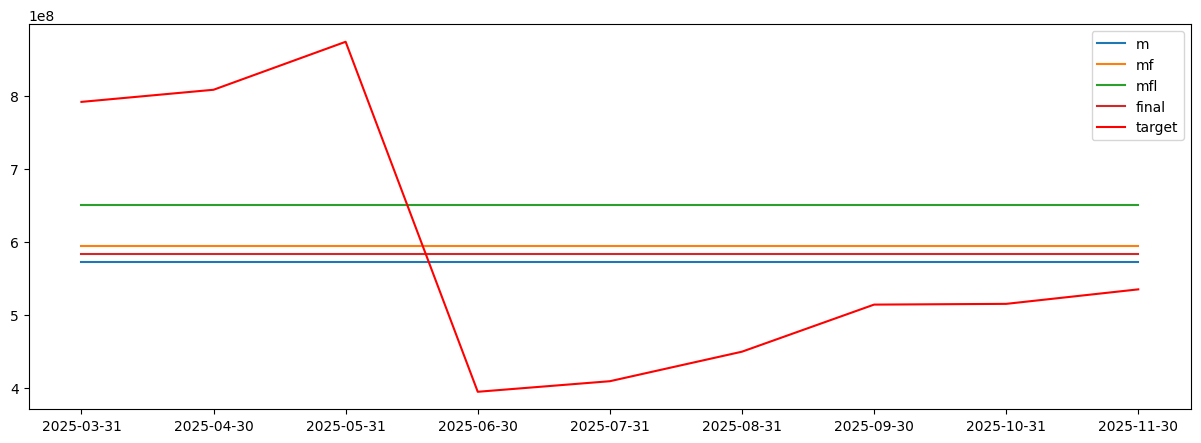

In [30]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)
results

## Random Forest

MSE on Train set:  1.4100306810192004e+16
MSE on Test set:  5.2733052193642824e+16


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.95161942e+08 3.72329620e+08 3.17190000e+08 3.98791041e+08
 4.40511207e+08 4.60176240e+08 4.59335678e+08 5.99893281e+08
 3.40210562e+08 4.19871603e+08 4.42170967e+08 4.44997959e+08
 5.00557893e+08 4.44997959e+08 4.44997959e+08 4.44997959e+08
 4.44997959e+08 4.44997959e+08 5.61740901e+08 5.72853909e+08
 6.45768355e+08 5.50711446e+08 4.76249851e+08 6.04914868e+08
 5.29218000e+08 6.94564273e+08 5.62050876e+08 5.40696562e+08
 5.62050876e+08 6.23163298e+08 6.23163298e+08 6.41402000e+08
 7.65988785e+08 4.19871603e+08 7.10113893e+08 4.19871603e+08
 5.35444603e+08 6.77293000e+08 7.10967000e+08 7.05398083e+08
 7.96238000e+08 7.65988785e+08 7.40283388e+08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,461306000.0,NaN,NaN,4.613060e+08,461306000.0
2019-02-28,503777000.0,NaN,NaN,5.037770e+08,503777000.0
2019-03-31,476975000.0,NaN,NaN,4.769750e+08,476975000.0
2019-04-30,476975000.0,NaN,NaN,4.769750e+08,525599000.0
2019-05-31,448817000.0,NaN,NaN,4.488170e+08,635907000.0
...,...,...,...,...,...
2024-10-31,612725000.0,941120000.0,NaN,7.402834e+08,941120000.0
2024-11-30,586924000.0,620313000.0,620313000.0,6.005467e+08,620313000.0
2024-12-31,653369000.0,612725000.0,612725000.0,6.367862e+08,612725000.0


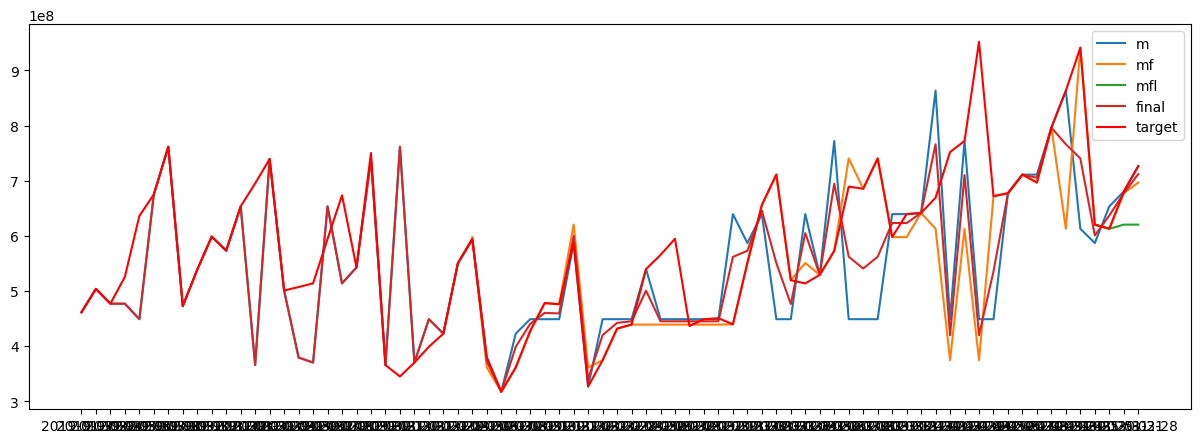

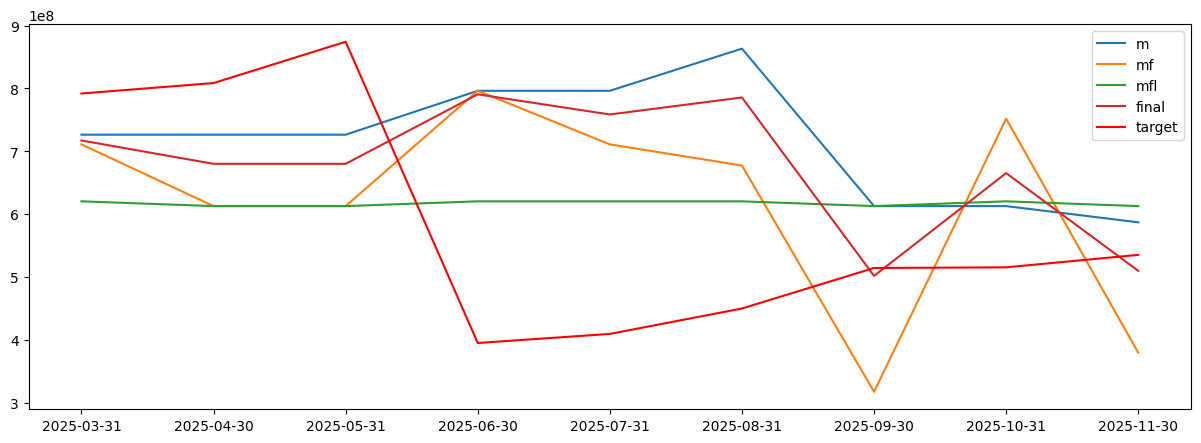

In [35]:
model_start = RandomForestClassifier(n_estimators=5, max_depth=5)
model_middle = RandomForestClassifier(n_estimators=5, max_depth=5)
model_end = RandomForestClassifier(n_estimators=1, max_depth=5)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)
results